# Worked through example of the variational bound

We will nox exemplify how we produced Figure 3 in [Limitations of optimization algorithms on noisy quantum devices](https://arxiv.org/abs/2009.05532). At the end of this notebook we will produce the plot showed there. 
We will exemplify our bound to compute the MAXCUT of a graph from the [GSet random graphs](https://www.cise.ufl.edu/research/sparse/matrices/Gset/). To download the instances in a format tailored for our code, please go [here](http://web.stanford.edu/~yyye/yyye/Gset/G12).
The Gset of instances is commonly used to benchmark the performance of algorithms for MAX-CUT. We chose the G12 instance, which corresponds to a graph with $n=800$ vertices and $1600$ edges. This results on an average degree of $\sim 4$. We start by importing the adjacency matrix of the graph, G12.csv. We saved it in this folder for convenience. This is done by the function import_instance. Note that we multiply the weights by 0.5 for normalization purposes later.

In [1]:

from scipy.sparse import csr_matrix, find
import random
import numpy as np
import time
import itertools
import pandas as pd

def import_instance(name_file):
    
    
    
    file1 = open(name_file, 'r') 
    Lines = file1.readlines()
    line0=Lines[0].split()
    n=int(line0[0])
    m=len(Lines)
    rows=[]
    columns=[]
    entries=[]
    for k in range(1,m):
        info_entry=Lines[k].split()
        rows.append(int(info_entry[0])-1)
        rows.append(int(info_entry[1])-1)
        columns.append(int(info_entry[1])-1)
        columns.append(int(info_entry[0])-1)
        entries.append(0.5*int(info_entry[2]))
        entries.append(0.5*int(info_entry[2]))
    A=csr_matrix((entries, (rows, columns)))
    return A
        
A=import_instance('G12.csv')

## From MAX-CUT to Ising models
It is well known that it is possible to recast the MAX-CUT problem into finding the ground state energy of an Ising model. Let us briefly recall how this is done to also ensure we have all right normalizations in place and know how to convert MAX-CUT values to Ising energies.

Given a weighted graph $G=(V,E)$ on $n$ vertices with adjacency matrix $A$, the MAX-CUT of $G$ is defined as the following optimization problem:
\begin{align*}
\max\limits_{s\in\{-1,1\}^n}\frac{1}{2}\sum\limits_{1\leq i<j\leq n}A_{ij}(1-s_is_j)
\end{align*}
This is a widely studied problem, as it is known to be NP-complete. 
It is then clear that it can be equivalently recast as:
\begin{align*}
\frac{1}{2}\sum\limits_{1\leq i<j\leq n}A_{ij}+\frac{1}{2}\max\limits_{s\in\{-1,1\}^n}\sum\limits_{1\leq i<j\leq n}-A_{ij}s_is_j=\\
\frac{1}{2}\sum\limits_{1\leq i<j\leq n}A_{ij}-\frac{1}{2}\min\limits_{s\in\{-1,1\}^n}\sum\limits_{1\leq i<j\leq n}A_{ij}s_is_j
\end{align*}
Note that the  first summand in the equation above, $\sum\limits_{1\leq i<j\leq n}A_{ij}$, is just a constant. Thus, solving MAX-CUT is equivalent to fiding the ground state energy of the Ising Hamiltonian:
\begin{align*}
H_I=\sum\limits_{1\leq i<j\leq n}A_{ij}Z_iZ_j.
\end{align*}
Moreover, if $C$ is the value achieved by a solution to MAX-CUT, the corresponding value for the energy $E$ of $H_I$ is given by:
\begin{align*}
\frac{1}{2}\sum\limits_{1\leq i<j\leq n}A_{ij}-2C.
\end{align*}

Now that we know how to convert MAX-CUT into Ising models, it is time to compute partition functions to apply our variational bound!
Recall that the variational bound asserts that for any quantum state $\rho$:
\begin{align*}
\operatorname{tr}(H_I\rho)\geq \sup\limits_{\beta\in(0,\beta_c)}\beta^{-1}(n-\log(\mathcal{Z}_\beta)-D(\rho\|I/2^n)).
\end{align*}
Here $\log(\mathcal{Z}_\beta)$ is the log-partition function of $H_I$ at inverse temperature $\beta$.

We will now compute the partition functions to evaluate the bound.

The first step is to compute the operator norm of this adjacency matrix. This allows us to compute up to which inverse temperature $\beta_c$ we know it to be efficient to estimate the partition function as per the results of [Theorem 11 of the linked reference](https://arxiv.org/pdf/2007.08200.pdf). 

In [8]:
from numpy import linalg as LA
[eigs,v]=LA.eig(A.todense())
norm=max(np.abs(eigs))
print("We can reliably go until beta",1/(2*norm))

We can reliably go until beta 0.281205921861218


After that we estimate the shifted log-partition function $\log(\mathcal{Z}_\beta)-n$ of the Hamiltonian:
\begin{align*}
H=\sum\limits_{i,j}A_{i,j}Z_iZ_j
\end{align*}
for $\beta\in(0,\beta_c)$, where $\beta_c$ was determined above.
As this is a computationally expensive step, so we will just import a list of $\beta$ and the corresponding value of $\log(\mathcal{Z}_\beta)-n$. The functions for estimating these partition functions are available in the repository.

In [9]:
results_part=pd.read_csv('results_part12.csv',header=None)
schedule=pd.read_csv('schedule12.csv',header=None)
results_part=results_part.values
schedule=schedule.values

We will now compute the term 
\begin{align*}
-\beta^{-1}\log\left(\frac{\mathcal{Z}_\beta}{2^{n}}\right)
\end{align*}
for the various values of beta we have:

In [10]:
def energy_estimates(partitions,schedule):
    energies=[]
    for k in range(1,len(partitions)):
        energies.append(-partitions[k]/schedule[k])
    return energies

energies=energy_estimates(results_part,schedule)

We are now able to plot an approximation to the curve:
\begin{align*}
f(x)=\sup\limits_{\beta\in(0,\beta_c)}\beta^{-1}\left(\log\left(\frac{\mathcal{Z}_\beta}{2^{n}}\right)-n\log(2)x\right)
\end{align*}
As shown in Prop. 2 of [Limitations of optimization algorithms on noisy quantum devices](https://arxiv.org/abs/2009.05532), the equation above gives a lower-bound on the output of the energy of a state $\rho$ with relative entropy density $x=1-n^{-1}S(\rho)$ under the Hamiltonian $H$. Let us implement a function that computes $f(x)$ and plot the curve:


In [11]:
def lower_bound(x,n,first_term,betas):
    lower_bounds=[]

    #the first element of the list will usually be beta=0, so we exclude it
    for k in range(1,len(first_term)):
        new_value=first_term[k]-(1/betas[k])*(np.log(2)*n*x)
        lower_bounds.append(new_value)
        
    return max(lower_bounds)/n

import matplotlib as mpl
import matplotlib.pyplot as plt

xs=np.linspace(0,1,100)
lower_bounds=[]
for x in xs:
    lower_bounds.append(lower_bound(x,800,energies,schedule))

plt.plot(xs,lower_bounds,'r',label="Lower bound on output")
plt.title("Variational bound for instance G12")
plt.xlabel('Relative entropy density')
plt.ylabel('Energy density')
plt.legend()    
    


We will now compare it to some values reported in the literature for the same instance and estimate the relative entropy density at which a noisy quantum device loses any potential advantage against said methods. We start with semidefinite programming (SDP) methods. In [Scalable Semidefinite Programming](https://arxiv.org/pdf/1912.02949.pdf), Table 3, the authors report a cut value of $524$ for G12 by running an SDP for 0.03s on a laptop.  We will first convert it to a corresponding energy of the Ising Hamiltonian for this  instance. After that, we will this point on the graph and shade the relative entropy densities for which it is not possible to obtain better expected values:

The maximal relative entropy density before we lose advantage compared to SDPs is 0.6363636363636365


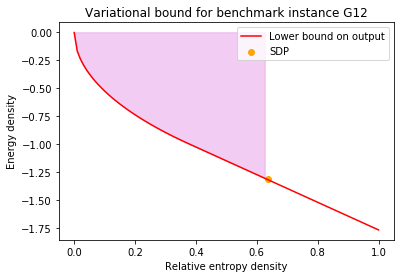

In [12]:
#computes the index for relative nentropy density when the lower-bound is lower then a given value
def find_crossover(results,value):
    k=0
    while (results[k]>value):
        k+=1
    return k

SDP_value=524
sum_A=np.sum(A)
energy_density=(sum_A-2*SDP_value)/800
k_SDP=find_crossover(lower_bounds,energy_density)
#convert lowerbounds to 1 dimension array
lower_bounds2=[]
for k in range(0,len(lower_bounds)):
    lower_bounds2.append(lower_bounds[k][0])

plt.fill_between(xs[0:k_SDP], lower_bounds2[0:k_SDP],alpha=1/5,color='m', edgecolor=None)
plt.scatter(xs[k_SDP],energy_density,color='orange',label="SDP")

plt.plot(xs,lower_bounds,'r',label="Lower bound on output")
plt.title("Variational bound for benchmark instance G12")
plt.xlabel('Relative entropy density')
plt.ylabel('Energy density')
plt.legend()    
print("The maximal relative entropy density before we lose advantage compared to SDPs is",xs[k_SDP])    

But we can also compare the value to heuristic solvers. To the best of our knowledge, the best value known for this instance is $556$ (see [here](https://medium.com/toshiba-sbm/benchmarking-the-max-cut-problem-on-the-simulated-bifurcation-machine-e26e1127c0b0)).

The maximal relative entropy density before we lose advantage compared to heuristic methods is 0.7070707070707072


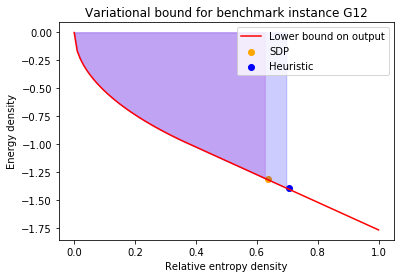

In [14]:
SDP_value=524
sum_A=np.sum(A)
energy_density=(sum_A-2*SDP_value)/800
k_SDP=find_crossover(lower_bounds,energy_density)
#convert lowerbounds to 1 dimension array
lower_bounds2=[]
for k in range(0,len(lower_bounds)):
    lower_bounds2.append(lower_bounds[k][0])

plt.fill_between(xs[0:k_SDP], lower_bounds2[0:k_SDP],alpha=1/5,color='m', edgecolor=None)
plt.scatter(xs[k_SDP],energy_density,color='orange',label="SDP")






heuristic_value=556
energy_density_heuristic=(sum_A-2*heuristic_value)/800
k_heuristic=find_crossover(lower_bounds,energy_density_heuristic)


plt.fill_between(xs[0:k_heuristic], lower_bounds2[0:k_heuristic],alpha=1/5,color='blue', edgecolor=None)
plt.scatter(xs[k_heuristic],energy_density_heuristic,color='blue',label="Heuristic")

plt.plot(xs,lower_bounds,'r',label="Lower bound on output")
plt.title("Variational bound for benchmark instance G12")
plt.xlabel('Relative entropy density')
plt.ylabel('Energy density')
plt.legend()   
plt.savefig('lower_bound_plot.pdf')
print("The maximal relative entropy density before we lose advantage compared to heuristic methods is",xs[k_heuristic])

The SDP performs pretty well compared to heuristic methods, as we see. But we conclude that the noisy device loses advantage under $1$-qubit depolarizing noise with probability $p$ at depths
\begin{align*}
D=-\frac{\log(0.70)}{2p}\simeq \frac{0.18}{p}.
\end{align*}

Finally, we will also plot the value achieved by simulated annealing for inverse temperatures in the polynomial-time range. Although the performance of this method to obtain solutions is worse than other polynomial time methods methods like SDPs, it is fairly universal (in the sense that it can be applied to a larger variety of problems other than MAX-CUT) and allows for analytical results on when we lose advantage. 

See our paper for more details! Here we will import the energy value we obtained with the Monte Carlo sampler you find in the repository.

The maximal relative entropy density before we lose advantage compared to annealing methods is 0.37373737373737376


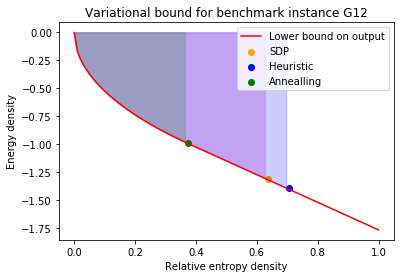

In [15]:
SDP_value=524
sum_A=np.sum(A)
energy_density=(sum_A-2*SDP_value)/800
k_SDP=find_crossover(lower_bounds,energy_density)
#convert lowerbounds to 1 dimension array
lower_bounds2=[]
for k in range(0,len(lower_bounds)):
    lower_bounds2.append(lower_bounds[k][0])

plt.fill_between(xs[0:k_SDP], lower_bounds2[0:k_SDP],alpha=1/5,color='m', edgecolor=None)
plt.scatter(xs[k_SDP],energy_density,color='orange',label="SDP")






heuristic_value=556
energy_density_heuristic=(sum_A-2*heuristic_value)/800
k_heuristic=find_crossover(lower_bounds,energy_density_heuristic)

plt.fill_between(xs[0:k_heuristic], lower_bounds2[0:k_heuristic],alpha=1/5,color='blue', edgecolor=None)
plt.scatter(xs[k_heuristic],energy_density_heuristic,color='blue',label="Heuristic")

energy_density_annealing=-791/800
k_annealing=find_crossover(lower_bounds,energy_density_annealing)




plt.fill_between(xs[0:k_annealing], lower_bounds2[0:k_annealing],alpha=1/5,color='green', edgecolor=None)
plt.scatter(xs[k_annealing],energy_density_annealing,color='green',label="Annealling")

plt.plot(xs,lower_bounds,'r',label="Lower bound on output")
plt.title("Variational bound for benchmark instance G12")
plt.xlabel('Relative entropy density')
plt.ylabel('Energy density')
plt.legend()   
plt.savefig('lower_bound_plot.pdf')
print("The maximal relative entropy density before we lose advantage compared to annealing methods is",xs[k_annealing])